In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization, Activation

2022-06-26 11:45:15.918501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-26 11:45:15.918566: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
model_asessment = tf.keras.models.load_model("conv_model_3")

2022-06-26 11:45:20.213886: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-26 11:45:20.213947: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (janPC): /proc/driver/nvidia/version does not exist
2022-06-26 11:45:20.214632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [49]:
BASE_DIR = './input/utkface-new/UTKFace/'

image_paths = []
age_labels = []
gender_labels = []
race_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    if len(temp) == 4:
        age = int(temp[0])
        gender = int(temp[1])
        race = int(temp[2])
        image_paths.append(image_path)
        age_labels.append(age)
        gender_labels.append(gender)
        race_labels.append(race)

  0%|          | 0/16383 [00:00<?, ?it/s]

In [50]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['race']= image_paths, age_labels, gender_labels, race_labels
df = df.sample(n=3000, random_state = 123)

In [51]:
def extract_features(images):
    features = []
    i=0
    for image in tqdm(images):
    
        img = load_img(image, grayscale=False, color_mode = "rgb", target_size = (128,128))
        #img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    #features = features.reshape(len(features), 128, 128, 1)
    return features

In [52]:
X = extract_features(df['image'])

  0%|          | 0/3000 [00:00<?, ?it/s]

In [53]:
X = X/255.0
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
y_race = np.array(df['race'])

In [57]:
result = model_asessment.predict(X)

94/94 [==============================] - 105s 1s/step


In [58]:
binary_conf_matrix = tf.math.confusion_matrix(result[0], y_gender)

In [59]:
binary_conf_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1480, 1461],
       [   1,   58]], dtype=int32)>

In [40]:
race_pred = []
for res in result[2]:
    race_pred.append(np.argmax(res))

In [41]:
multiclass_conf_matrix = tf.math.confusion_matrix(race_pred, y_race[:100])

In [42]:
multiclass_conf_matrix

<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[26,  2,  2,  3,  2],
       [ 2, 14,  1,  2,  1],
       [ 5,  0,  8,  1,  1],
       [ 5,  1,  0, 12,  1],
       [ 4,  0,  2,  2,  3]], dtype=int32)>

In [43]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

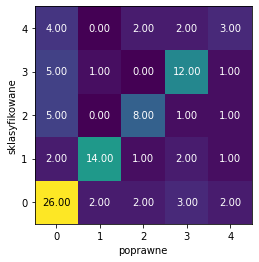

In [46]:
heatmap(multiclass_conf_matrix, xlabel='poprawne', xticklabels=[0,1,2,3,4], ylabel='sklasyfikowane', yticklabels=[0,1,2,3,4], cmap="viridis")
plt.show()

In [47]:
from sklearn.metrics import r2_score

In [48]:
r2_score(y_age, result[1])

0.7271805888515437